In [1]:
#Import of packages
import pandas as pd
import palettable
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
#import geopandas
#import shapely

import math
import numpy as np
import random
# setup plotting tools
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.pylab import *
from matplotlib.colors import LogNorm
from matplotlib.colors import SymLogNorm
import matplotlib.colors
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import colorConverter as cc
from matplotlib.gridspec import GridSpec as GS
#from util import lexsort_rows



import networkx as nx
from matplotlib.patches import Polygon
from pylab import rcParams
from matplotlib.collections import PatchCollection
from mpl_toolkits.axes_grid1 import ImageGrid
import warnings
from numpy.linalg import matrix_power
warnings.filterwarnings('ignore')
%run -i General_Function.py

# Draw the data

In [2]:
def Generate_B1(df):
    L = len(df)
    N = max(df.max())
    B1 = np.zeros((N,L))
    for index, row in df.iterrows():
        B1[row["A"]-1,index] = -1
        B1[row["B"]-1,index] = 1
    return B1

In [3]:
df_coordinate = pd.read_excel("Fungi.xlsx", sheet_name="Sheet1")
pos = {}
for i in range(1,len(df_coordinate)+1):
    pos[i] = [df_coordinate["x"].iloc[i-1], df_coordinate["y"].iloc[i-1]]
df_edges = pd.read_excel("Fungi.xlsx", sheet_name="Sheet2")
df_edges[["edge", "length"]] = df_edges["Name"].str.split('    ', expand=True)
df_edges[["A", "B"]] = df_edges["edge"].str.split(',', expand=True)
df_edges['A'] = pd.to_numeric(df_edges['A'].str.replace('(', ''))
df_edges['B'] = pd.to_numeric(df_edges['B'].str.replace(')', ''))
edge_list = []
for edge in df_edges[['A', 'B']].to_numpy().tolist():
    if edge[1] > edge[0]:
        edge_list.append(edge)

B1 = Generate_B1(pd.DataFrame(edge_list, columns=["A", "B"]))
N, L = B1.shape
D1 = np.block([[np.zeros((N,N)),B1],[B1.transpose(),np.zeros((L,L))]])

Gamma = np.block([[np.identity(N),np.zeros((N,L))],
                  [np.zeros((L,N)), -np.identity(L)]])

# Visualization (Figure 1)

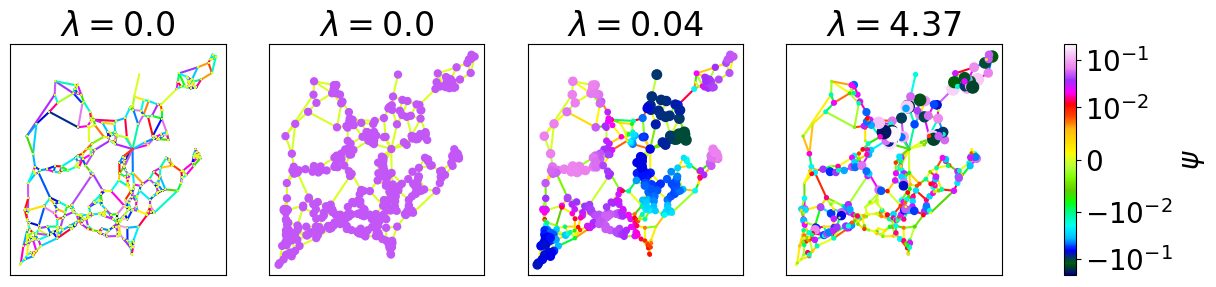

In [60]:
matplotlib.rcParams.update({'font.size': 20})
colormap = plt.cm.gist_ncar

alpha_1 = 0.0
alpha_2 = 0.0
D = D1
m = 1.5
positions = [500, 645, 650, 930]
#Different eigenvectors (not noisy)

four_signals = np.array([generate_signals_eigenvalues_FF(D + m * Gamma, N, L, alpha_1, alpha_2, position)[1] for position in positions])
four_lambdas = np.array([generate_signals_eigenvalues_FF(D + m * Gamma, N, L, alpha_1, alpha_2, position)[0] ** 2 - m ** 2 for position in positions])
norm = SymLogNorm(linthresh=0.01,
    vmin= -np.max(np.abs(four_signals)), 
    vmax=np.max(np.abs(four_signals)),
    base=10
)

color_maps = [[colormap(norm(value)) for value in signal] for signal in four_signals]


Titles = [r"$\lambda = $" + str(round(l,2)) for l in four_lambdas]
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(16, 3))
                    
    
for i, ax in enumerate(axes.flat):
    for j in range(len(edge_list)):
        edge = edge_list[j]
        x1 = pos[edge[0]][0]
        x2 = pos[edge[0]][1]
        y1 = pos[edge[1]][0]
        y2 = pos[edge[1]][1]
        ax.plot([x1,y1], [x2,y2], color = color_maps[i][N + j], zorder = 1)
    
    ax.scatter(df_coordinate['x'], df_coordinate['y'], s = np.abs(four_signals[i][:N]) * 500, c = color_maps[i][:N], zorder = 2)
    ax.set_title(Titles[i])
    ax.set_xticks([])
    ax.set_yticks([])

sm = plt.cm.ScalarMappable(cmap=colormap, norm=norm)
sm.set_array([])
plt.colorbar(sm, label=r"$\psi$", ax=axes)
plt.show()

# Minimizing Loss and relativistic dispersion relation error (Figure 3)

In [8]:
position = 930
m = 1.5
alpha = 0.3
Lambda, psi_true, psi_tilde = generate_signals_eigenvalues_F(D + m * Gamma, alpha ,position)
True_error_f, Loss_f, Dispersion_f, m_list_f = compare_error(D, psi_true, psi_tilde, Gamma, 0.0,3.0)

<Figure size 640x200 with 0 Axes>

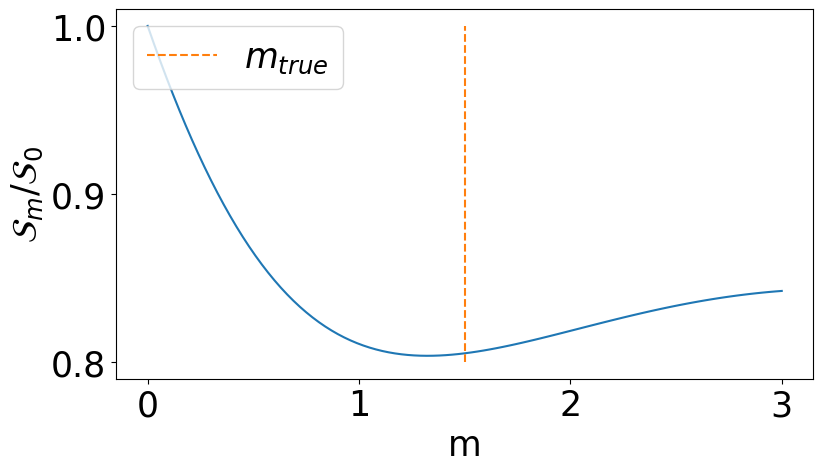

<Figure size 640x200 with 0 Axes>

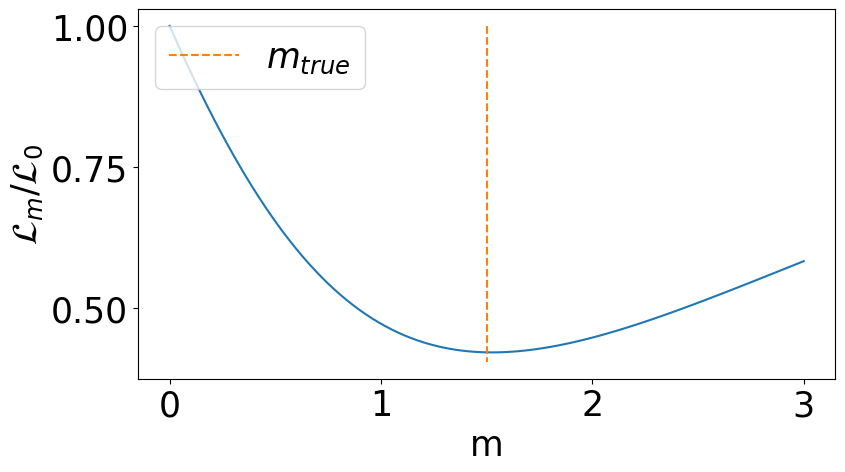

<Figure size 640x200 with 0 Axes>

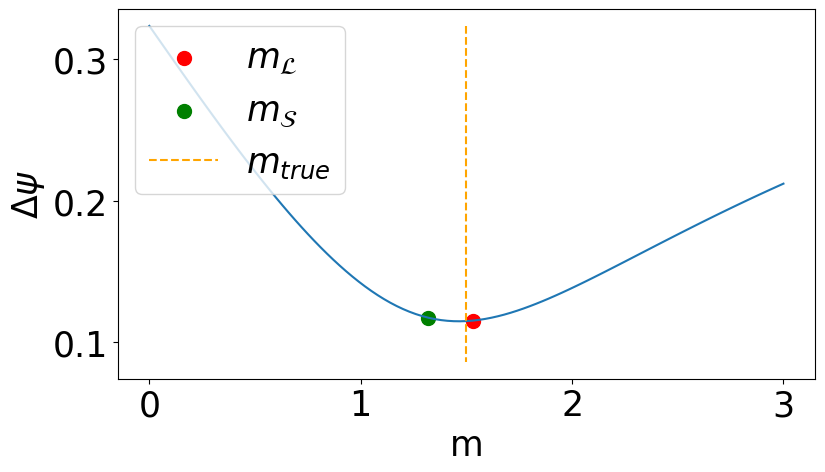

In [14]:
matplotlib.rcParams.update({'font.size': 25})
plt.figure().set_figheight(2)
plt.figure().set_figwidth(9)
plt.plot(m_list_f, np.array(Dispersion_f)/Dispersion_f[0])
plt.plot(m * np.ones(len(m_list_f)), np.linspace( 0.8, 1.0 ,len(m_list_f)), "--", label = r"$m_{true}$")
plt.ylabel(r"$\mathcal{S}_m/\mathcal{S}_0$")
plt.yticks([0.8,0.9,1.0])
plt.xlabel("m")
plt.legend(loc = "upper left")
plt.show()


matplotlib.rcParams.update({'font.size': 25})
plt.figure().set_figheight(2)
plt.figure().set_figwidth(9)
plt.plot(m_list_f, np.array(Loss_f)/Loss_f[0])
plt.plot(m * np.ones(len(m_list_f)), np.linspace(max(Loss_f)/Loss_f[0], min(Loss_f)/Loss_f[0] * 0.96,len(m_list_f)), "--", label = r"$m_{true}$")
plt.ylabel(r"$\mathcal{L}_m/\mathcal{L}_0$")
plt.yticks([0.5,0.75,1.0])
plt.xlabel("m")
plt.legend(loc = "upper left")
plt.show()

matplotlib.rcParams.update({'font.size': 25})
plt.figure().set_figheight(2)
plt.figure().set_figwidth(9)
plt.plot(m_list_f, np.array(True_error_f))
plt.scatter(m_list_f[np.argmin(Loss_f)], True_error_f[np.argmin(Loss_f)], s = 100, color = "red", label = r"$m_\mathcal{L}$")
plt.scatter(m_list_f[np.argmin(Dispersion_f)], True_error_f[np.argmin(Dispersion_f)], color = "green" , s = 100, label = r"$m_\mathcal{S}$")
plt.plot(m * np.ones(len(m_list_f)), np.linspace(max(True_error_f),min(True_error_f) * 0.75,len(m_list_f)), "--", label = r"$m_{true}$", color = "orange")

plt.xticks([0,1,2,3])
plt.yticks([0.1, 0.2, 0.3])
plt.xlabel("m")
plt.ylabel(r"$\Delta \psi$")
plt.legend(loc="upper left")
plt.show()